In [51]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from create_data import create_input_data_tensor

from functions import sigmoid_tensor, relu


class WakeSleepModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lr = 0.1
        
        self.i_num = 16
        self.j_num = 8
        self.k_num = 1
        
        # 内部状態 バイナリ値をとる 0 or 1
        self.s_i = torch.zeros(self.i_num)
        self.s_j = torch.zeros(self.j_num)
        self.s_k = torch.zeros(self.k_num)
        
        # ニューロンが興奮する確率 連続値をとる 0~1
        self.p_i = torch.zeros(self.i_num)
        self.p_j = torch.zeros(self.j_num)
        self.p_k = torch.zeros(self.k_num)
        
        # 前向きの線形変換
        self.liner_f_ij = nn.Linear(self.i_num, self.j_num)
        self.liner_f_jk = nn.Linear(self.j_num, self.k_num)
        
        # 逆向きの線形変換
        self.liner_b_0k = nn.Linear(1, self.k_num) # トップダウンのシングルバイアスを実現するために追加　#この重みはつねに0で学習せず、バイアスのみを学習する
        self.liner_b_kj = nn.Linear(self.k_num, self.j_num)
        self.liner_b_ji = nn.Linear(self.j_num, self.i_num)        
        
        # パラメータの初期化 全部ゼロにしてるけど、適切な初期化方法があるかも
        # self.liner_b_0kの重みだけは0で固定
        nn.init.normal_(self.liner_f_ij.weight, mean=0, std=1)
        nn.init.normal_(self.liner_f_ij.bias, mean=0, std=1)
        nn.init.normal_(self.liner_f_jk.weight, mean=0, std=1)
        nn.init.normal_(self.liner_f_jk.bias, mean=0, std=1)
        nn.init.normal_(self.liner_b_0k.weight)
        nn.init.normal_(self.liner_b_0k.bias, mean=0, std=1)
        nn.init.normal_(self.liner_b_kj.weight, mean=0, std=1)
        nn.init.normal_(self.liner_b_kj.bias, mean=0, std=1)
        nn.init.normal_(self.liner_b_ji.weight, mean=0, std=1)
        nn.init.normal_(self.liner_b_ji.bias, mean=0, std=1)
        
        # nn.init.zeros_(self.liner_f_ij.weight)
        # nn.init.zeros_(self.liner_f_ij.bias)
        # nn.init.zeros_(self.liner_f_jk.weight)
        # nn.init.zeros_(self.liner_f_jk.bias)
        # nn.init.zeros_(self.liner_b_0k.weight)
        # nn.init.zeros_(self.liner_b_0k.bias)
        # nn.init.zeros_(self.liner_b_kj.weight)
        # nn.init.zeros_(self.liner_b_kj.bias)
        # nn.init.zeros_(self.liner_b_ji.weight)
        # nn.init.zeros_(self.liner_b_ji.bias)

    # 確率に従ってサンプリング（0,1を決定)
    def sampling(self, x):
        return torch.bernoulli(x)
    
    # 前向きに順番に計算
    def recognize(self, input_data):
        # 前向きの計算
        # 内部状態を更新
        
        self.s_i = input_data
        tmp_j = sigmoid_tensor(self.liner_f_ij(self.s_i))
        self.s_j = self.sampling(tmp_j)
        
        tmp_k = sigmoid_tensor(self.liner_f_jk(self.s_j))
        self.s_k = self.sampling(tmp_k)
    
    def feedback(self):
        # 逆向きの計算
        self.p_k = sigmoid_tensor(self.liner_b_0k(torch.ones(1)))
        self.p_j = sigmoid_tensor(self.liner_b_kj(self.s_k))
        self.p_i = sigmoid_tensor(self.liner_b_ji(self.s_j))
    
    def wake_phase(self ,input_data):
        self.recognize(input_data)
        self.feedback()
        
        # 重みの更新
        diff_k = self.s_k - self.p_k
        diff_j = self.s_j - self.p_j
        diff_i = self.s_i - self.p_i
        
        # 0kは重みを更新しない　バイアスのみ更新
        self.liner_b_0k.bias.data += self.lr * diff_k
        self.liner_b_kj.weight.data += self.lr * (diff_j.reshape(self.j_num,1)) @ (self.s_k.reshape(1,self.k_num))
        self.liner_b_kj.bias.data += self.lr * diff_j
        
        self.liner_b_ji.weight.data += self.lr * (diff_i.reshape(self.i_num,1)) @ (self.s_j.reshape(1,self.j_num))
        self.liner_b_ji.bias.data += self.lr * diff_i
        
        relu(self.liner_b_0k.bias.data)
        relu(self.liner_b_kj.weight.data)
        relu(self.liner_b_kj.bias.data)
        relu(self.liner_b_ji.weight.data)
        relu(self.liner_b_ji.bias.data )
        
        
    
    def generate(self):
        # 逆向きの計算
        # 内部状態を更新
        tmp_k = sigmoid_tensor(self.liner_b_0k(torch.ones(1)))
        self.s_k = self.sampling(tmp_k)
        tmp_j = sigmoid_tensor(self.liner_b_kj(self.s_k))
        self.s_j = self.sampling(tmp_j)
        tmp_i = sigmoid_tensor(self.liner_b_ji(self.s_j))
        self.s_i = self.sampling(tmp_i)
        
    def feedforward(self):
        # p_iはいらない
        self.p_j = sigmoid_tensor(self.liner_f_ij(self.s_i))
        self.p_k = sigmoid_tensor(self.liner_f_jk(self.s_j))
        
        
    def sleep_phase(self):
        self.generate()
        self.feedforward()
        
        diff_j = self.s_j - self.p_j
        diff_k = self.s_k - self.p_k
        
        # 重みの更新
        self.liner_f_ij.weight.data += self.lr * (diff_j.reshape(self.j_num,1)) @ (self.s_i.reshape(1,self.i_num))
        self.liner_f_ij.bias.data += self.lr * diff_j
        self.liner_f_jk.weight.data += self.lr * (diff_k.reshape(self.k_num,1)) @ (self.s_j.reshape(1,self.j_num))
        self.liner_f_jk.bias.data += self.lr * diff_k
        
        relu(self.liner_f_ij.weight.data)
        relu(self.liner_f_ij.bias.data)
        relu(self.liner_f_jk.weight.data)
        relu(self.liner_f_jk.bias.data)
        


In [52]:
ws = WakeSleepModel()

for i in range(100000):
    input_data= create_input_data_tensor()
    ws.wake_phase(input_data)
    ws.sleep_phase()

tensor([1.], grad_fn=<BernoulliBackward0>)


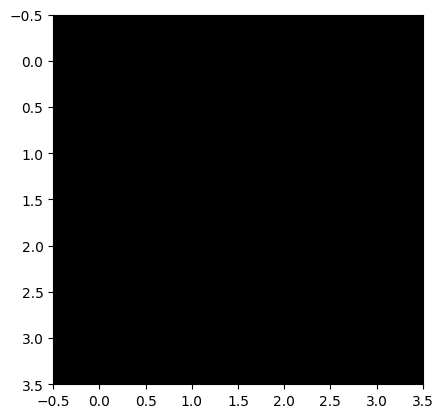

tensor([1.], grad_fn=<BernoulliBackward0>)


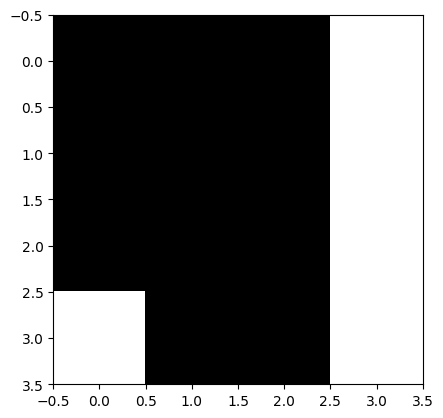

tensor([1.], grad_fn=<BernoulliBackward0>)


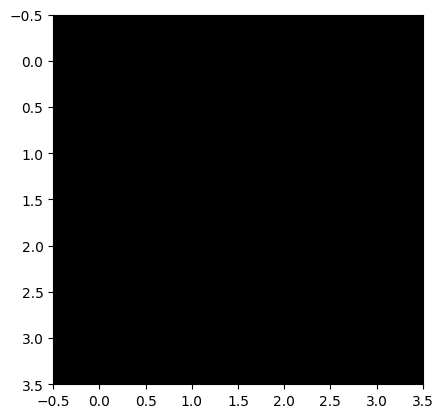

tensor([0.], grad_fn=<BernoulliBackward0>)


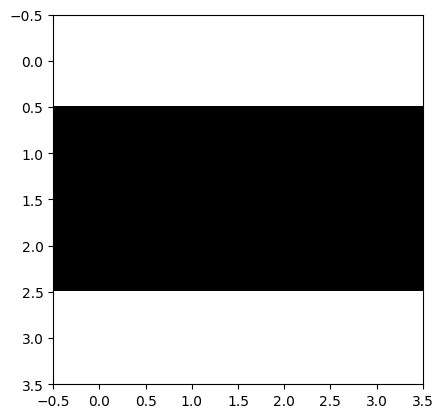

tensor([1.], grad_fn=<BernoulliBackward0>)


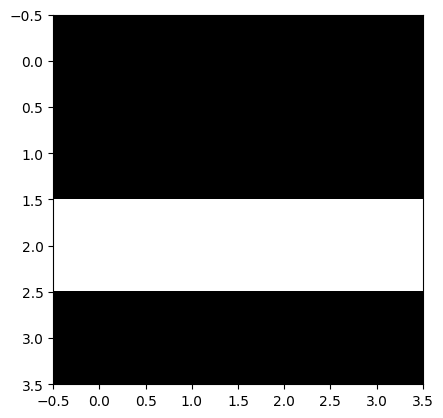

tensor([1.], grad_fn=<BernoulliBackward0>)


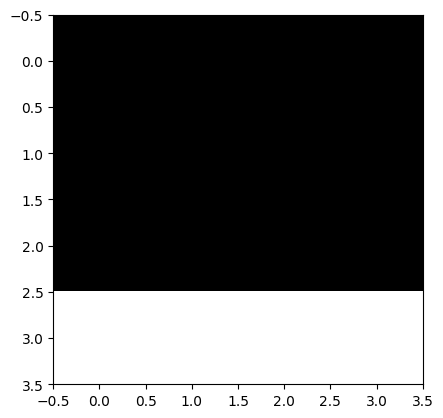

tensor([1.], grad_fn=<BernoulliBackward0>)


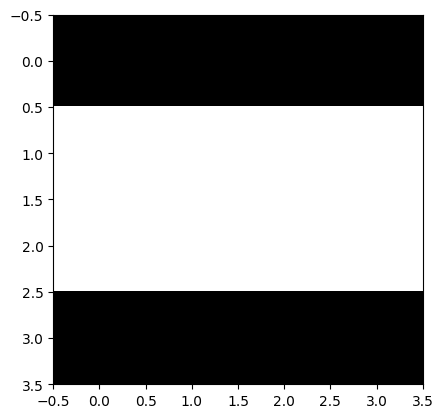

tensor([1.], grad_fn=<BernoulliBackward0>)


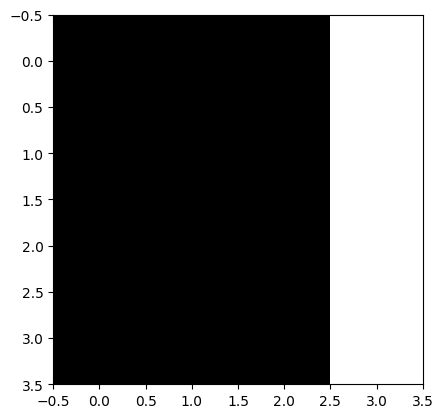

tensor([0.], grad_fn=<BernoulliBackward0>)


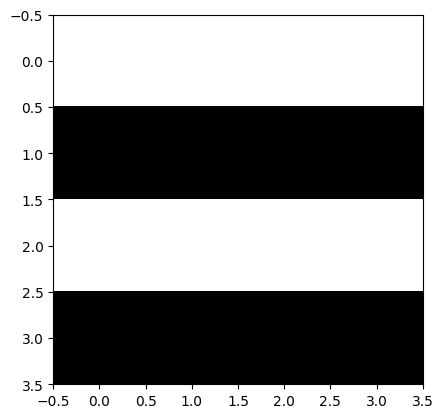

tensor([0.], grad_fn=<BernoulliBackward0>)


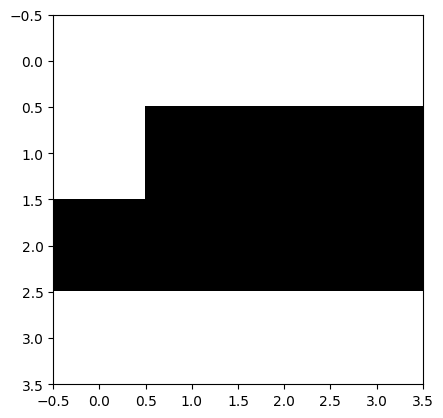

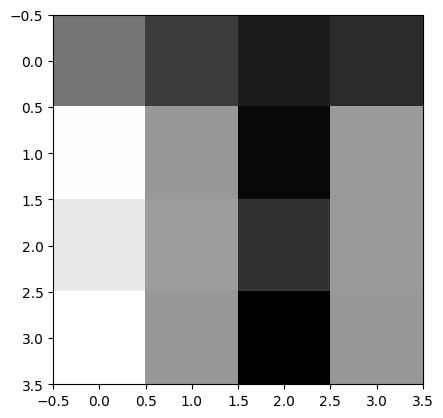

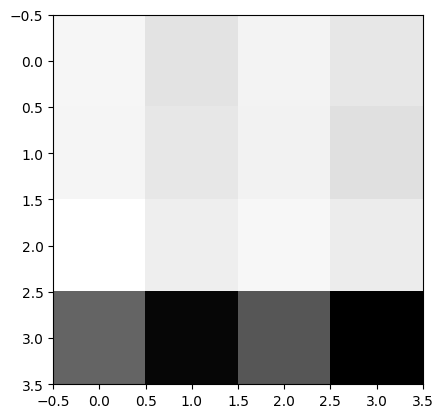

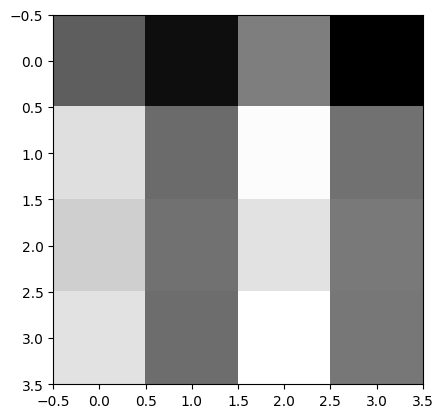

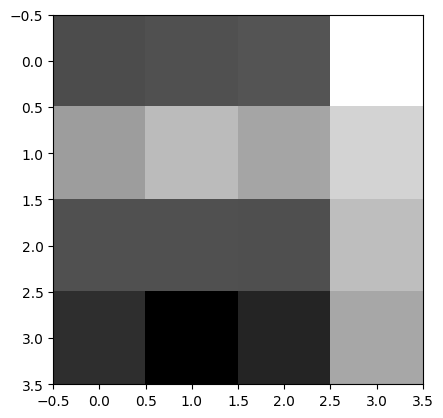

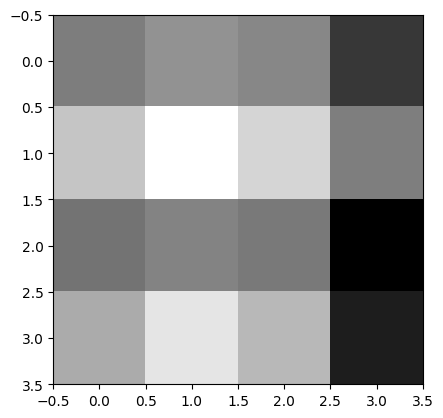

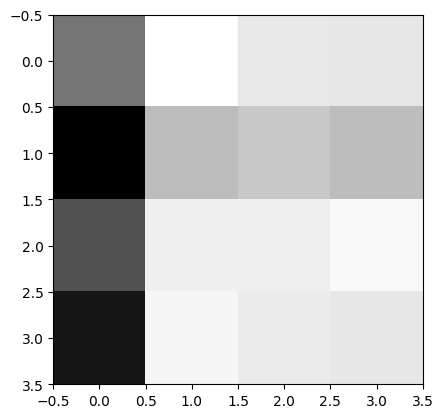

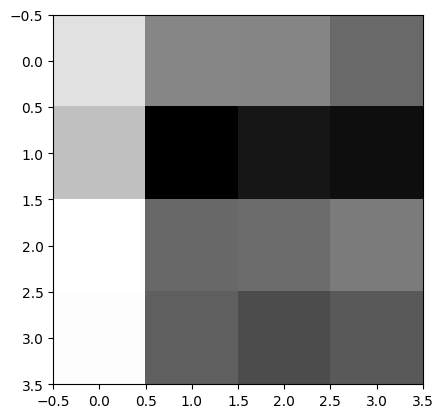

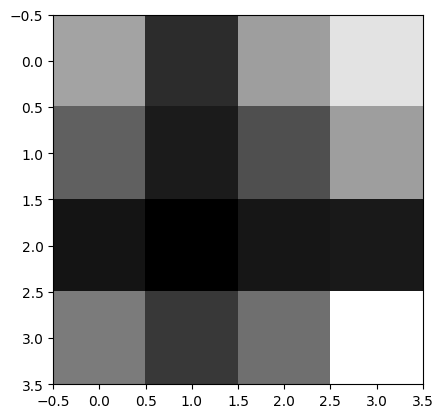

In [53]:
# input_data= create_input_data_tensor()
# image = input_data.view(4, 4)
# plt.imshow(image.numpy(), cmap='gray')
# plt.show()

for i in range(10):
    ws.generate()
    image = ws.s_i.data.view(4, 4)
    plt.imshow(image.numpy(), cmap='gray')
    # plt.savefig('generateImage/positiveweight_{}'.format(i))
    print(ws.s_k)
    plt.show()


for i in range(8):
    image = ws.liner_b_ji.weight.data[:,i].view(4, 4)

    # Visualize
    plt.imshow(image.numpy(), cmap='gray')
    # plt.savefig('weightImage/positiveweight_{}.png'.format(i))
    # plt.colorbar()
    plt.show()
